The most importance features that predict future user adoption are 'creation_source' and 'org_id'.
 
To identify the factors that predict future user adoption, we analyzed the user_engagement data. A new column, 'adopted', was created to indicate whether a user had logged into the product on three separate days within any seven-day period. This column was then merged with the users dataset to explore its relationship with other user attributes.

We examined correlations between adopted and several binary variables, including 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', and 'invited_by_user'. No strong correlations were observed.

Next, we analyzed the probability of adoption as a function of the multi-categorical variables 'org_id' (Figure 1) and 'creation_source' (Figure 2). Clear dependencies were found, suggesting that these factors are more predictive of user adoption.

The results were corroborated by the feature importance analysis (Figure 3) from the XGBoost model, which predicted user adoption with an accuracy of 0.85.

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
df_enga = pd.read_csv('takehome_user_engagement.csv')

In [3]:
df_enga.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
df_enga['time_stamp'] = pd.to_datetime(df_enga['time_stamp'])
df_enga.dtypes

time_stamp    datetime64[ns]
user_id                int64
visited                int64
dtype: object

In [5]:
import numpy as np
from collections import deque

def rolling_7day_count(group):
    timestamps = group['time_stamp']
    counts = []
    window = deque()
    
    for t in timestamps:
        # Remove timestamps older than t - 7 days
        while window and (t - window[0]).days > 7:
            window.popleft()
        window.append(t)
        counts.append(len(window))
    
    group = group.copy()
    group['last_7days'] = counts
    return group

In [6]:
count_7days = df_enga.groupby('user_id').apply(rolling_7day_count,include_groups=False)
df_adopted =  count_7days.groupby('user_id').agg(adopted = pd.NamedAgg(column='last_7days', aggfunc=lambda x: np.max(x) >=3) )
df_adopted.head(10)

,adopted
user_id,
1,False
2,True
3,False
4,False
5,False
6,False
7,False
10,True
11,False


In [7]:
df_user = pd.read_csv('takehome_users.csv',encoding='latin-1')

In [8]:
df_user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


### Concatenate 'adopted' to users data

In [9]:
df_user.rename(columns = {'object_id':'user_id'},inplace=True)
df_user = df_user.set_index('user_id')

In [10]:
pd.set_option('future.no_silent_downcasting', True)
df_user_enga = pd.concat([df_user,df_adopted], axis=1)
df_user_enga.fillna({'adopted':False}, inplace=True)#.astype('bool')

In [11]:
# convert date columns to datetime objects
df_user_enga['creation_time'] = pd.to_datetime(df_user_enga['creation_time'])
df_user_enga['last_session_creation_time'] = pd.to_datetime(df_user_enga['last_session_creation_time'],unit='s')

# create a new bool column to indicate whether a user was invited by other user. 
df_user_enga['invited_by_user'] = df_user_enga['invited_by_user_id'] 
df_user_enga['invited_by_user'] =df_user_enga['invited_by_user'] >0
df_user_enga=df_user_enga.fillna({'invited_by_user':False})

In [12]:
df_user_enga.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,invited_by_user
user_id,,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,False,True
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,True,True
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,False,True
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,False,True
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,False,True


### Look at correlations with Categorical Variables  

In [13]:
df_user_enga.creation_source.unique()

array(['GUEST_INVITE', 'ORG_INVITE', 'SIGNUP', 'PERSONAL_PROJECTS',
       'SIGNUP_GOOGLE_AUTH'], dtype=object)

In [14]:
bicat = ['adopted','opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'invited_by_user']
df_user_enga[bicat].corr()

,adopted,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user
adopted,1.000000,0.008838,0.006578,0.027831
opted_in_to_mailing_list,0.008838,1.000000,0.483529,0.006934
enabled_for_marketing_drip,0.006578,0.483529,1.000000,0.002216
invited_by_user,0.027831,0.006934,0.002216,1.000000


In [15]:
multicat= ['creation_source','org_id']
bicat+multicat

['adopted',
 'opted_in_to_mailing_list',
 'enabled_for_marketing_drip',
 'invited_by_user',
 'creation_source',
 'org_id']

Users with orgaination 387 has the highest probability of 0.583 to adopt.


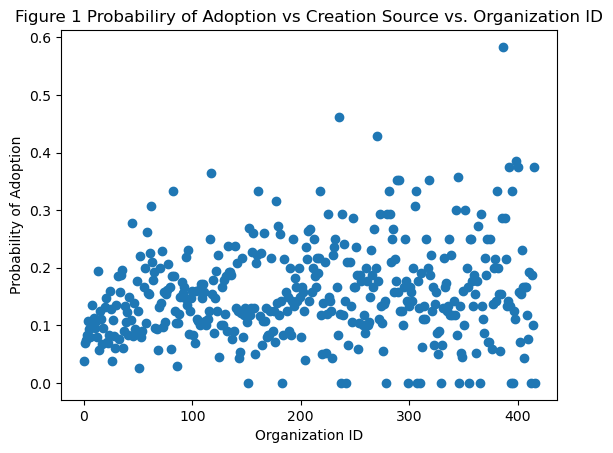

In [16]:
org_id = df_user_enga.groupby('org_id')['adopted'].mean()
plt.scatter(org_id.index, org_id.values)
plt.xlabel('Organization ID')
plt.ylabel('Probability of Adoption')
plt.title('Figure 1 Probabiliry of Adoption vs Creation Source vs. Organization ID')
print(f'Users with orgaination {org_id[org_id>0.5].index[0]} has the highest probability of {org_id[org_id>0.5].values[0]:.3f} to adopt.')

Text(0.5, 1.0, 'Figure 2 Probabiliry of Adoption vs. Creation Source')

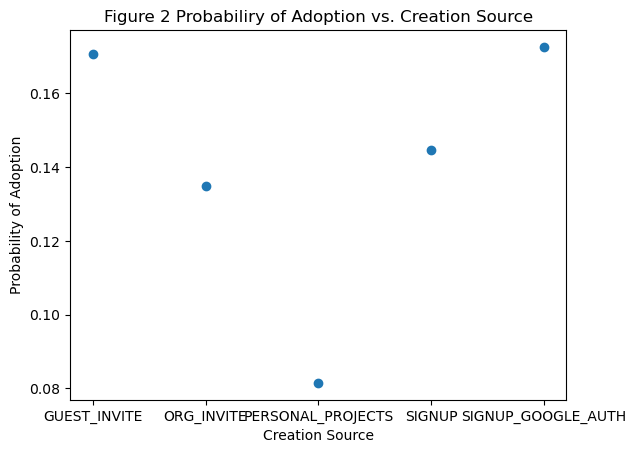

In [17]:
cre_src = df_user_enga.groupby('creation_source')['adopted'].mean()
plt.scatter(cre_src.index, cre_src.values)
plt.xlabel('Creation Source')
plt.ylabel('Probability of Adoption')
plt.title('Figure 2 Probabiliry of Adoption vs. Creation Source')

In [18]:
df_cat = df_user_enga[bicat+multicat]
y= df_cat.pop('adopted').astype('bool')
X = pd.get_dummies(df_cat)

In [19]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [20]:
# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.2, random_state=42)


In [21]:
# Initialize and train XGBoost classifier
model = xgb.XGBClassifier(eval_metric='logloss')
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8533333333333334


Text(0.5, 1.0, 'Figure 3 Feature Importance')

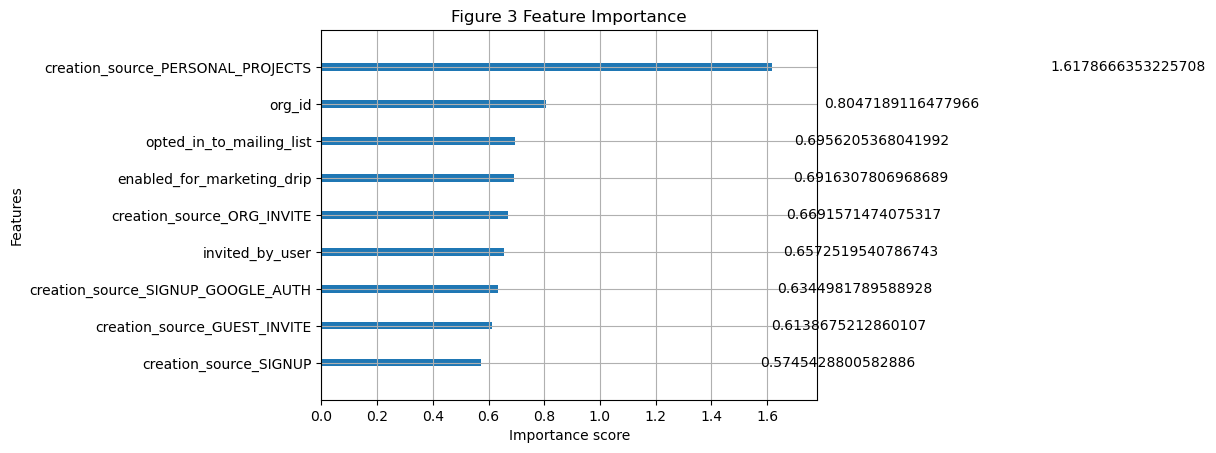

In [22]:
xgb.plot_importance(model, importance_type='gain')
plt.title('Figure 3 Feature Importance')